# Binary classification using word embeddings and CNN

#### Aaron Anderson

In this notebook, we investigate using word embeddings and convolutional neural network architectures for a binary classification problem. We use two different sources for pre-trained word embeddings (Google's word2vec and Stanford's GloVe), and we compare CNN accuracy to a suite of alternative algorithms trained on standard bag-of-words methods.

---
### 1. Imports

In [39]:
import numpy as np
import pandas as pd
import string
import os
import csv
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, concatenate, Dense, Dropout, Activation, Embedding, Conv1D, GlobalMaxPooling1D, BatchNormalization, Flatten
from sklearn.naive_bayes import GaussianNB
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models.keyedvectors import KeyedVectors

---
### 2. Load labeled data

In [40]:
df = pd.read_csv('labeled_data.csv')
df = df.dropna(subset = ['topics', 'text'])
display(df.head())
print(f'The data has {df.shape[0]} rows.')

/Users/ama/NWRC/Venv/cnn-nlp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,1,2,10,11,18,22,23,25,26,28,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Identity,topics,sentiment,created_at,text,user_loc,user_desc,coords,geo,place,...,user_lang,user_following,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,source_file
0,conservative,control,-1,Sat Jun 01 03:59:44 +0000 2019,(Agricultural) DIVERSITY is OUR STRENGTH... #t...,"Ottawa, Ontario",11th Gen. Cdn. (1653) Conservative. Retired sm...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_feralswine_05012019to11042019.csv
1,She,concern,0,Tue Aug 06 17:39:49 +0000 2019,People posted the O RLY owl for like three yea...,Ebou Dar,She/Her ~ Somewhere on the ace/aro spectrum ~ ...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_wildpigs_05012019to11042019.csv
2,Student,info,0,Tue Aug 06 07:31:55 +0000 2019,I fight back the tears at my children's funera...,"Tucson, AZ",Like all of my tweets are going to be video g...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_wildpigs_05012019to11042019.csv
3,Farmer,concern,-1,Sun May 26 20:59:04 +0000 2019,Feral swine amassed at Montana‚Äôs northern bo...,New York State,"Female dairy farmer (4th generation), assistan...",NaN,NaN,NaN,...,NaN,NaN,NaN,False,11,21,False,False,en,results_feralswine_05012019to11042019.csv
4,"Reporter, Military",concern,-1,Wed Aug 07 18:19:35 +0000 2019,What a sentence by @AlexHortonTX: Millions of ...,Washington,Reporter @washingtonpost. Formerly at @starsan...,NaN,NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,en,results_wildhogs_05012019to11042019.csv


The data has 1360 rows.


In [41]:
df.loc[df.index[-1], :]

Identity                                                                   NaN
topics                                                                  basmen
sentiment                                                                    0
created_at                                      Tue Aug 06 01:17:54 +0000 2019
text                         a wild pack of feral hogs \ncame running throu...
user_loc                                                      Arl/Med/Som/Cam 
user_desc                    ABOLITIONIST. COMMUNIST. Also: Ladies' Man, Ma...
coords                                                                     NaN
geo                                                                        NaN
place                                                                      NaN
retweet                                                                   True
truncated                                                                False
hashtags                                            

In [3]:
category = np.zeros(df.shape[0], dtype=np.int8)
category[df.topics != '0'] = 1
texts = np.array(df.text)
print(category.shape)
print(texts.shape)

(1360,)
(1360,)


In [4]:
print(f"Fraction relevant = {round(np.sum(category == 1) / df.shape[0], 2)}")
print(f"Fraction not relevant = {round(np.sum(category == 0) / df.shape[0], 2)}")

Fraction relevant = 0.7
Fraction not relevant = 0.3


---
### 3. Functions for data organization

In [5]:
def split_sample(category, texts, val_start, val_end):
    """ Splits both relevant and texts arrays into validation and train arrays. """
    
    category_val = category[val_start:val_end + 1]
    texts_val = texts[val_start:val_end + 1]
    category_train = np.delete(category, range(val_start, val_end + 1))
    texts_train = np.delete(texts, range(val_start, val_end + 1))
    
    return category_val, texts_val, category_train, texts_train

In [6]:
def y_to_int(category_val, category_train):
    """ Convert y vectors to 0, 1 vectors. """
    if category_val is not None:
        labels_val = np.zeros(len(category_val), dtype=np.int8)
        labels_val[category_val == 1] = 1
    else:
        labels_val = None

    labels_train = np.zeros(len(category_train), dtype=np.int8)
    labels_train[category_train == 1] = 1

    return labels_val, labels_train

In [7]:
def get_bow_matrix(x_train, x_val, NUM_WORDS, MAX_SEQUENCE_LENGTH):
    """ Build bow matrix from x data. """
    x_train_bow = np.zeros((x_train.shape[0], NUM_WORDS + 1))
    x_val_bow = np.zeros((x_val.shape[0], NUM_WORDS + 1))

    for i in range(x_train.shape[0]):
        for j in range(MAX_SEQUENCE_LENGTH):
            x_train_bow[i, x_train[i, j]] = 1

    for i in range(x_val.shape[0]):
        for j in range(MAX_SEQUENCE_LENGTH):
            x_val_bow[i, x_val[i, j]] = 1
            
    return x_val_bow, x_train_bow

In [8]:
def build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH=None):
    """ Get sequences associated with rows (integer number of words). """
    tokenizer = Tokenizer(num_words=NUM_WORDS, lower=True)
    tokenizer.fit_on_texts(texts_train)
    sequences_train = tokenizer.texts_to_sequences(texts_train)
    if texts_val is not None:
        sequences_val = tokenizer.texts_to_sequences(texts_val)
    
    if MAX_SEQUENCE_LENGTH is None:
        MAX_SEQUENCE_LENGTH = 0
        for sequence in sequences_train:
            if len(sequence) > MAX_SEQUENCE_LENGTH:
                MAX_SEQUENCE_LENGTH = len(sequence)
        # print('Max sequence len =', MAX_SEQUENCE_LENGTH)
    
    word_index = tokenizer.word_index
    # print('Found %s unique tokens' % len(word_index))

    data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
    if texts_val is not None:
        data_val = pad_sequences(sequences_val, maxlen=MAX_SEQUENCE_LENGTH)
    else:
        data_val = None
    
    return data_val, data_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer

---
### 4. Functions to get word embeddings

Consider the phrases 'have a good time' and 'have a great time'. We need some way to represent these numerically. One-hot encoding based on bag-of-words (BOW) is a conventional technique. In this example, our BOW is `(have, a, good, great, time)`. If we represent a single word with a vector of these elements we would have: <br>
* `[1, 0, 0, 0, 0]` for 'have'
* `[0, 0, 1, 0, 0]` for 'good'
* `[0, 0, 0, 1, 0]` for 'great'

The shortcoming of this representation is that the distance (in 5-dimensional space) between 'have' and 'good' is exactly the same as the distance between 'good' and 'great'. Yet we know that 'have' and 'good' have very different meanings and 'good' and 'great' have very similar meanings.  

What we would like is a vector representation of a word that is similar to the vectors that represent different words that appear in similar contexts. Google's Word2Vec is a method to construct these vectors. Consider the following neural network architecture:

<img src="images/Skipgram.png" alt="Drawing" style="width: 500px;"/>

The input is a one-hot vector for 'good', and the output is series of one-hot vectors for context words. Essentially, we are feeding the network a target word and predicting context information. If we were to train this network on large amounts of written text, it would learn the vector representation of each target word. In fact, the vector representation (the embedding) is the vector __h__ associated with the word. Since words with similar meanings tend to appear in similar contexts, the embeddings for similar words will be similar vectors.

To employ word embeddings, we first build an index of the top n (e.g. 1000) words that appear in our dataset. Each word is assigned a unique integer. We then build a vector for each tweet by replacing each word with its integer value. These vectors retain information on both word prescence and word order. We then pad each sequence so that all sequences are the same length (we pre-pad with zeros). At this point our data has a number of rows equal to the number of tweets and a number of columns equal to the length of our sequences. Finally, we replace the integer value of each word with the embedding vector of each word. Our data is now 3-dimensional with a row for each tweet, a column for word, and a sheet for each element of the word embedding vectors.

However, to make it easier to visualize the convolutional network architecture, we will rotate the data such that we have a row for each word, a column for each element of the embedding vector, and a sheet for each tweet.

`data shape = (length of sequences, length of embedding vectors, number of tweets)`

In [9]:
def get_embedding_index(glove=True):

    if glove:
        GLOVE_DIR = '../Data/embeddings/glove.twitter.27B'
        embeddings_index = {}
        f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'))
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
    else:
        filepath = "../Data/embeddings/GoogleNews-vectors-negative300.bin"
        embeddings_index = {}
        wv_from_bin = KeyedVectors.load_word2vec_format(filepath, binary=True) 
        for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
            coefs = np.asarray(vector, dtype='float32')
            embeddings_index[word] = coefs

    return embeddings_index

In [10]:
def get_embedding_matrix(EMBEDDING_DIM, word_index, embeddings_index):

    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # print(embedding_matrix.shape)
    return embedding_matrix

---
### 5. Functions for evaluating simple algorithms

In [11]:
def get_rf_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = RandomForestClassifier(n_estimators=500, min_samples_split=4)
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('RF training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('RF validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    precision = precision_score(y_val, y_pred_val) 
    recall = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    
    return acc, precision, recall, f1

In [12]:
def get_nb_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = GaussianNB()
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('NB training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('NB validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    precision = precision_score(y_val, y_pred_val) 
    recall = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    
    return acc, precision, recall, f1

In [13]:
def get_svm_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = svm.SVC(kernel='linear')
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('SVM training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('SVM validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    precision = precision_score(y_val, y_pred_val) 
    recall = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    
    return acc, precision, recall, f1

In [14]:
def get_logit_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    clf = LogisticRegression(random_state=0, solver='lbfgs')
    clf.fit(x_train_bow, y_train)

    y_pred_train = clf.predict(x_train_bow)
    #print('Logit training accuracy =', accuracy_score(y_train, y_pred_train))

    y_pred_val = clf.predict(x_val_bow)
    print('Logit validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    precision = precision_score(y_val, y_pred_val) 
    recall = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    
    return acc, precision, recall, f1

In [15]:
def get_mlp_acc(x_train_bow, y_train, x_val_bow, y_val):
    
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=x_train_bow.shape[1]))
    model.add(Dropout(0.50))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train_bow, y_train,
              batch_size=1280,
              epochs=75,
              validation_data=(x_val_bow, y_val),
              verbose=False)
    
    y_pred_val = model.predict_classes(x_val_bow)
    print('MLP validation accuracy =', round(accuracy_score(y_val, y_pred_val), 3))
    
    acc = accuracy_score(y_val, y_pred_val)
    precision = precision_score(y_val, y_pred_val) 
    recall = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    
    return acc, precision, recall, f1

---
### 7. Evaluation of simple BOW methods

We need to set aside a portion of our data to test our trained algorithm. We could set aside a single validation set, but suppose we happen to draw a random selection of tweets for the validation set that are particularly easy (or difficult) to classify? The solution is to use a procedure called k-fold cross-validation to ensure that all tweets appear in the validation set exactly once.

<img src="images/kfold.png" alt="Drawing" style="width: 600px;"/>

For each fold, we calculate four different accuracy metrics.

`Accuracy = percent of labels that are correct`

`Precision = true positives / (true positives + false positives)` <br>
If we pile up tweets that our classifier labels as relevant, precision increases as the percentage of true positives in that pile increases. So we might have a small pile, but precision will be high if the tweets in that pile are truely relevant.<br>

`Recall = true positives / (true positives + false negatives)` <br>
Note that a false negative is a relevant tweet we label as non-relevant. You can see that recall decline as we mislabel relevant tweets as non-relevant. Thus, recall increases as long as we correctly label relevant tweets, regardless of how many non-relevant tweets we label as relvant.

`F1 = harmonic mean of precision and recall` <br>
Valuable when a balance between precision and recall is desirable and the distribution of classes is unequal.

<img src="images/Precisionrecall.png" alt="Drawing" style="width: 600px;"/>

In [16]:
NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = None

rf = {'acc': [], 'precision': [], 'recall': [], 'f1': []}
nb = {'acc': [], 'precision': [], 'recall': [], 'f1': []}
sv = {'acc': [], 'precision': [], 'recall': [], 'f1': []}
logit = {'acc': [], 'precision': [], 'recall': [], 'f1': []}
mlp = {'acc': [], 'precision': [], 'recall': [], 'f1': []}


for k in range(0, 5):
    print('')
    print('Validation on fold ' + str(k + 1) + '.')
    val_start = round(df.shape[0] * k / 5)
    val_end = round(df.shape[0] * (k + 1) / 5) - 1
    category_val, texts_val, category_train, texts_train = split_sample(category, texts, val_start, val_end)

    x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH)

    y_val, y_train = y_to_int(category_val, category_train)

    # print('Validation data shape =', x_val.shape)
    # print('Train data shape =', x_train.shape)

    # print('Validation labels shape =', y_val.shape)
    # print('Train labels shape =', y_train.shape)

    x_val_bow, x_train_bow = get_bow_matrix(x_train, x_val, NUM_WORDS, MAX_SEQUENCE_LENGTH)
    # print('BOW train data shape =', x_train_bow.shape)
    # print('BOW val data shape =', x_val_bow.shape)

    acc, precision, recall, f1 = get_rf_acc(x_train_bow, y_train, x_val_bow, y_val)
    rf['acc'].append(acc)
    rf['precision'].append(precision)
    rf['recall'].append(recall)
    rf['f1'].append(f1)
    
    acc, precision, recall, f1 = get_nb_acc(x_train_bow, y_train, x_val_bow, y_val)
    nb['acc'].append(acc)
    nb['precision'].append(precision)
    nb['recall'].append(recall)
    nb['f1'].append(f1)
    
    acc, precision, recall, f1 = get_svm_acc(x_train_bow, y_train, x_val_bow, y_val)
    sv['acc'].append(acc)
    sv['precision'].append(precision)
    sv['recall'].append(recall)
    sv['f1'].append(f1)
    
    acc, precision, recall, f1 = get_logit_acc(x_train_bow, y_train, x_val_bow, y_val)
    logit['acc'].append(acc)
    logit['precision'].append(precision)
    logit['recall'].append(recall)
    logit['f1'].append(f1)
    
    acc, precision, recall, f1 = get_mlp_acc(x_train_bow, y_train, x_val_bow, y_val)
    mlp['acc'].append(acc)
    mlp['precision'].append(precision)
    mlp['recall'].append(recall)
    mlp['f1'].append(f1)


Validation on fold 1.
RF validation accuracy = 0.838
NB validation accuracy = 0.688
SVM validation accuracy = 0.787
Logit validation accuracy = 0.831
MLP validation accuracy = 0.82

Validation on fold 2.
RF validation accuracy = 0.816
NB validation accuracy = 0.735
SVM validation accuracy = 0.798
Logit validation accuracy = 0.798
MLP validation accuracy = 0.779

Validation on fold 3.
RF validation accuracy = 0.846
NB validation accuracy = 0.713
SVM validation accuracy = 0.82
Logit validation accuracy = 0.835
MLP validation accuracy = 0.801

Validation on fold 4.
RF validation accuracy = 0.871
NB validation accuracy = 0.702
SVM validation accuracy = 0.838
Logit validation accuracy = 0.86
MLP validation accuracy = 0.857

Validation on fold 5.
RF validation accuracy = 0.915
NB validation accuracy = 0.684
SVM validation accuracy = 0.864
Logit validation accuracy = 0.868
MLP validation accuracy = 0.882


In [17]:
print('ACCURACY')
print('random forest =', round(np.mean(rf['acc']), 3))
print('naive bayes =', round(np.mean(nb['acc']), 3))
print('support vector =', round(np.mean(sv['acc']), 3))
print('logit regress =', round(np.mean(logit['acc']), 3))
print('standard mlp =', round(np.mean(mlp['acc']), 3))
print('')

print('PRECISION')
print('random forest =', round(np.mean(rf['precision']), 3))
print('naive bayes =', round(np.mean(nb['precision']), 3))
print('support vector =', round(np.mean(sv['precision']), 3))
print('logit regress =', round(np.mean(logit['precision']), 3))
print('standard mlp =', round(np.mean(mlp['precision']), 3))
print('')

print('RECALL')
print('random forest =', round(np.mean(rf['recall']), 3))
print('naive bayes =', round(np.mean(nb['recall']), 3))
print('support vector =', round(np.mean(sv['recall']), 3))
print('logit regress =', round(np.mean(logit['recall']), 3))
print('standard mlp =', round(np.mean(mlp['recall']), 3))
print('')

print('F1')
print('random forest =', round(np.mean(rf['f1']), 3))
print('naive bayes =', round(np.mean(nb['f1']), 3))
print('support vector =', round(np.mean(sv['f1']), 3))
print('logit regress =', round(np.mean(logit['f1']), 3))
print('standard mlp =', round(np.mean(mlp['f1']), 3))

ACCURACY
random forest = 0.857
naive bayes = 0.704
support vector = 0.821
logit regress = 0.838
standard mlp = 0.828

PRECISION
random forest = 0.851
naive bayes = 0.872
support vector = 0.878
logit regress = 0.871
standard mlp = 0.843

RECALL
random forest = 0.964
naive bayes = 0.674
support vector = 0.862
logit regress = 0.901
standard mlp = 0.925

F1
random forest = 0.903
naive bayes = 0.76
support vector = 0.87
logit regress = 0.885
standard mlp = 0.881


---
### 6. CNN build

Convolutional neural networks are common architectures in computer vision tasks due to the very large number of features associated with each sample. Consider a relatively small color image that is 100x100 pixels. This image would contain 30,000 features (100 * 100 * 3 color channels). If we were were to assemble a conventional neural network with a single dense hidden layer of 100 nodes, we would have (30000 * 100 + 1) + (100 + 1) parameters to estimate. 

Our problem is not as extreme as some image problems, but we still have a large number of features. For example, we might allow a sequence length of 50 and have word embedding vectors that contain 300 elements. Thus, each tweet is represented by 50 * 300 features. 

To understand how a convolutional network reduces the number of trainable parameters, consider:

<img src="images/filter.png" alt="Drawing" style="width: 600px;"/>

In this very simple example, we slide a filter over the data representing a single tweet. The filter contains a number of parameters equal to 3 times the length of the embedding vectors (7 in this case). So, instead of estimating weights on 56 features, we train 21 weights in the filter. In practice, our sequence are much longer so that the benefits of a CNN are more pronounces.

The architecture we use is demonstrated in the figure below. We start with an embedding layer and feed the output of that layer into a 1d convolutional layer. We then use max pooling before a a fully-connected layer. The activation functions for both the convolutional and dense layers are RELU, and our final activation is softmax.

![](images/cnn.png)

In [18]:
def fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, 
                  HIDDEN_DIMS, EPOCHS, DROPOUT_RATE, MAX_SEQUENCE_LENGTH, 
                  x_train, y_train, x_val, y_val, word_index, embedding_matrix, verbose):

    tweet_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    tweet_encoder = Embedding(len(word_index) + 1, EMBEDDING_DIMS, weights=[embedding_matrix], 
                              input_length=MAX_SEQUENCE_LENGTH, trainable=False)(tweet_input)
    bigram_branch = Conv1D(filters=FILTERS, kernel_size=2, padding='valid', 
                           activation='relu', strides=1)(tweet_encoder)
    bigram_branch = GlobalMaxPooling1D()(bigram_branch)
    trigram_branch = Conv1D(filters=FILTERS, kernel_size=3, padding='valid', 
                            activation='relu', strides=1)(tweet_encoder)
    trigram_branch = GlobalMaxPooling1D()(trigram_branch)
    fourgram_branch = Conv1D(filters=FILTERS , kernel_size=4, padding='valid', 
                             activation='relu', strides=1)(tweet_encoder)
    fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
    
    merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

    merged = Dense(HIDDEN_DIMS, activation='relu')(merged)
    merged = Dropout(DROPOUT_RATE)(merged)
    merged = Dense(1)(merged)
    
    output = Activation('sigmoid')(merged)
    model = Model(inputs=[tweet_input], outputs=[output])
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    # print(model.summary())

    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(x_val, y_val),
                        verbose=verbose)
    
    score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=False)
    print('CNN validation accuracy:', acc)
    
    probs = model.predict(x_val, batch_size=BATCH_SIZE, verbose=False)
    fitted = probs > 0.5


    precision = precision_score(y_val, fitted) 
    recall = recall_score(y_val, fitted)
    f1 = f1_score(y_val, fitted)
        
    return model, acc, precision, recall, f1, history, probs, fitted

---
### 8. Evaluation of CNN with GloVe embeddings

In [19]:
embeddings_index_glove = get_embedding_index(glove=True)

In [27]:
MAX_SEQUENCE_LENGTH = None
EMBEDDING_DIMS = 100
NUM_WORDS = 1000
BATCH_SIZE = 1280
FILTERS = 32
HIDDEN_DIMS = 128
EPOCHS = 50
DROPOUT_RATE = 0.4

cnn1 = {'acc': [], 'precision': [], 'recall': [], 'f1': []}
histories = []

for k in range(0, 5):
    print('')
    print('Validation on fold ' + str(k + 1) + '.')
    val_start = round(df.shape[0] * k / 5)
    val_end = round(df.shape[0] * (k + 1) / 5) - 1
    
    category_val, texts_val, category_train, texts_train = split_sample(category, texts, val_start, val_end)

    x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH)
    print(MAX_SEQUENCE_LENGTH)
    y_val, y_train = y_to_int(category_val, category_train)

    # print('Validation data shape =', x_val.shape)
    # print('Train data shape =', x_train.shape)

    # print('Validation labels shape =', y_val.shape)
    # print('Train labels shape =', y_train.shape)

    embedding_matrix = get_embedding_matrix(EMBEDDING_DIMS, word_index, embeddings_index_glove)

    _, acc, precision, recall, f1, history, probs, fitted = fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, HIDDEN_DIMS, 
                                                                          EPOCHS, DROPOUT_RATE, MAX_SEQUENCE_LENGTH,
                                                                          x_train, y_train, x_val, y_val, 
                                                                          word_index, embedding_matrix, verbose=False)

    histories.append(history)
    cnn1['acc'].append(acc)
    cnn1['precision'].append(precision)
    cnn1['recall'].append(recall)
    cnn1['f1'].append(f1)
    


Validation on fold 1.
63
CNN validation accuracy: 0.8161764740943909

Validation on fold 2.
63
CNN validation accuracy: 0.841911792755127

Validation on fold 3.
63
CNN validation accuracy: 0.8566176295280457

Validation on fold 4.
63
CNN validation accuracy: 0.8566176295280457

Validation on fold 5.
63
CNN validation accuracy: 0.875


<IPython.core.display.Javascript object>


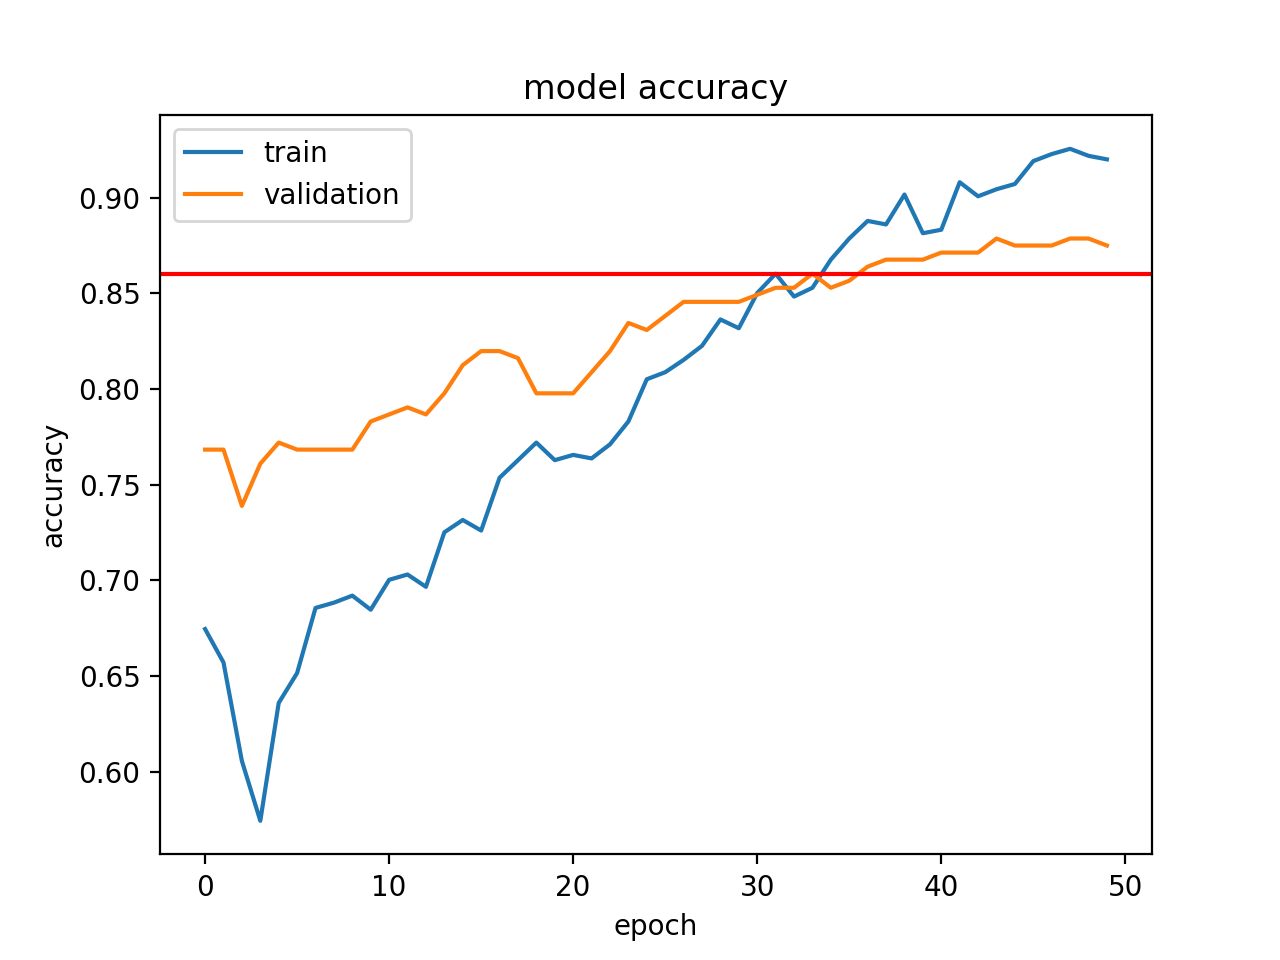

In [28]:
fold = 4

plt.rcParams['figure.figsize'] = [6, 4]

%matplotlib notebook
plt.plot(histories[fold].history['accuracy'])
plt.plot(histories[fold].history['val_accuracy'])
plt.axhline(y=0.86, color='r', linestyle='-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [29]:
print('ACCURACY')
print('cnn1 =', np.mean(cnn1['acc']))
print('')

print('PRECISION')
print('cnn1 =', np.mean(cnn1['precision']))
print('')

print('RECALL')
print('cnn1 =', np.mean(cnn1['recall']))
print('')

print('F1')
print('cnn1 =', np.mean(cnn1['f1']))

ACCURACY
cnn1 = 0.8492647051811218

PRECISION
cnn1 = 0.8592100220012272

RECALL
cnn1 = 0.9387043578146919

F1
cnn1 = 0.896230820649004


---
### 9. Evaluation of CNN with word2vec embeddings

In [30]:
embeddings_index_google = get_embedding_index(glove=False)

In [31]:
MAX_SEQUENCE_LENGTH = None
EMBEDDING_DIMS = 300
NUM_WORDS = 1000
BATCH_SIZE = 1280
FILTERS = 32
HIDDEN_DIMS = 128
EPOCHS = 50
DROPOUT_RATE = 0.4

cnn2 = {'acc': [], 'precision': [], 'recall': [], 'f1': []}
histories = []

for k in range(0, 5):
    print('')
    print('Validation on fold ' + str(k + 1) + '.')
    val_start = round(df.shape[0] * k / 5)
    val_end = round(df.shape[0] * (k + 1) / 5) - 1
    
    category_val, texts_val, category_train, texts_train = split_sample(category, texts, val_start, val_end)

    x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH)

    y_val, y_train = y_to_int(category_val, category_train)

    # print('Validation data shape =', x_val.shape)
    # print('Train data shape =', x_train.shape)

    # print('Validation labels shape =', y_val.shape)
    # print('Train labels shape =', y_train.shape)

    embedding_matrix = get_embedding_matrix(EMBEDDING_DIMS, word_index, embeddings_index_google)

    _, acc, precision, recall, f1, history, probs, fitted = fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, HIDDEN_DIMS, 
                                                                          EPOCHS, DROPOUT_RATE, MAX_SEQUENCE_LENGTH,
                                                                          x_train, y_train, x_val, y_val, 
                                                                          word_index, embedding_matrix, verbose=False)

    histories.append(history)
    cnn2['acc'].append(acc)
    cnn2['precision'].append(precision)
    cnn2['recall'].append(recall)
    cnn2['f1'].append(f1)
    


Validation on fold 1.
CNN validation accuracy: 0.8639705777168274

Validation on fold 2.
CNN validation accuracy: 0.8529411554336548

Validation on fold 3.
CNN validation accuracy: 0.8786764740943909

Validation on fold 4.
CNN validation accuracy: 0.8786764740943909

Validation on fold 5.
CNN validation accuracy: 0.9227941036224365


<IPython.core.display.Javascript object>


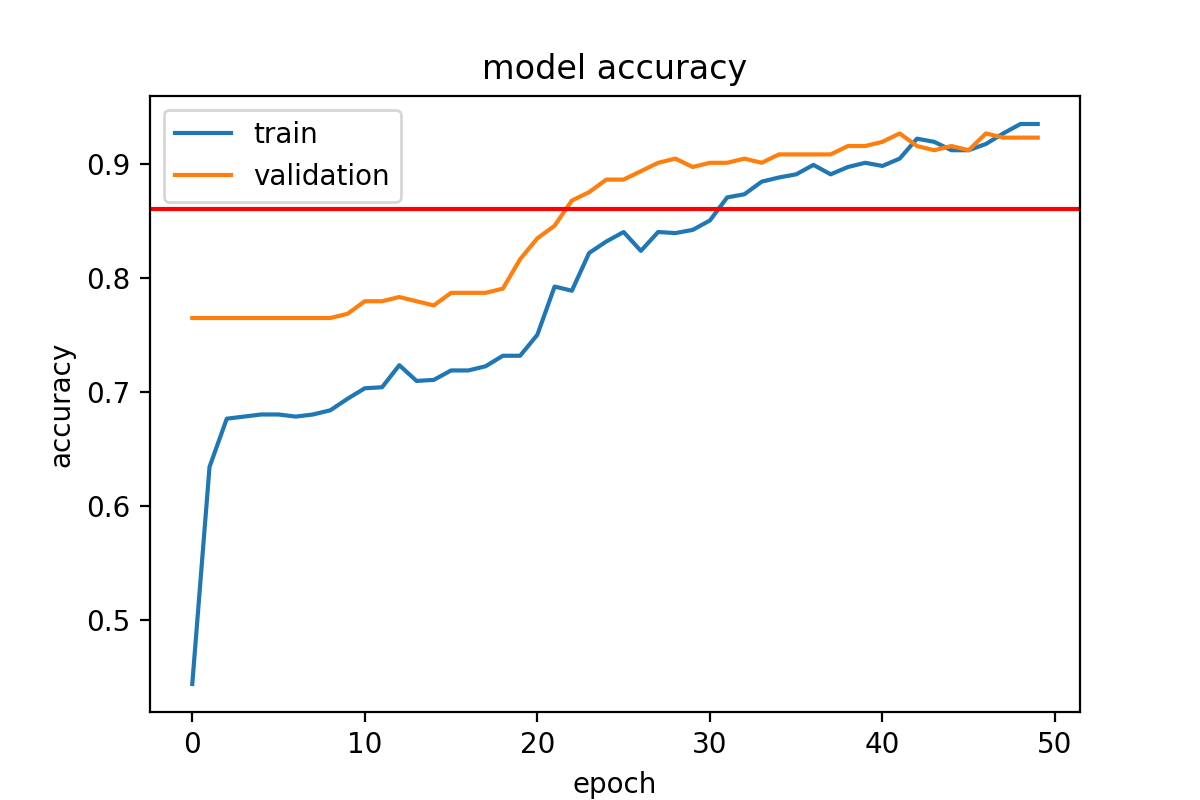

In [32]:
fold = 4

plt.rcParams['figure.figsize'] = [6, 4]

%matplotlib notebook
plt.plot(histories[fold].history['accuracy'])
plt.plot(histories[fold].history['val_accuracy'])
plt.axhline(y=0.86, color='r', linestyle='-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
print('ACCURACY')
print('cnn2 =', np.mean(cnn2['acc']))
print('')

print('PRECISION')
print('cnn2 =', np.mean(cnn2['precision']))
print('')

print('RECALL')
print('cnn2 =', np.mean(cnn2['recall']))
print('')

print('F1')
print('cnn2 =', np.mean(cnn2['f1']))

ACCURACY
cnn2 = 0.8794117569923401

PRECISION
cnn2 = 0.8888936871964874

RECALL
cnn2 = 0.9459446640527588

F1
cnn2 = 0.9155654728741451


---
### 10. Comparison

<IPython.core.display.Javascript object>


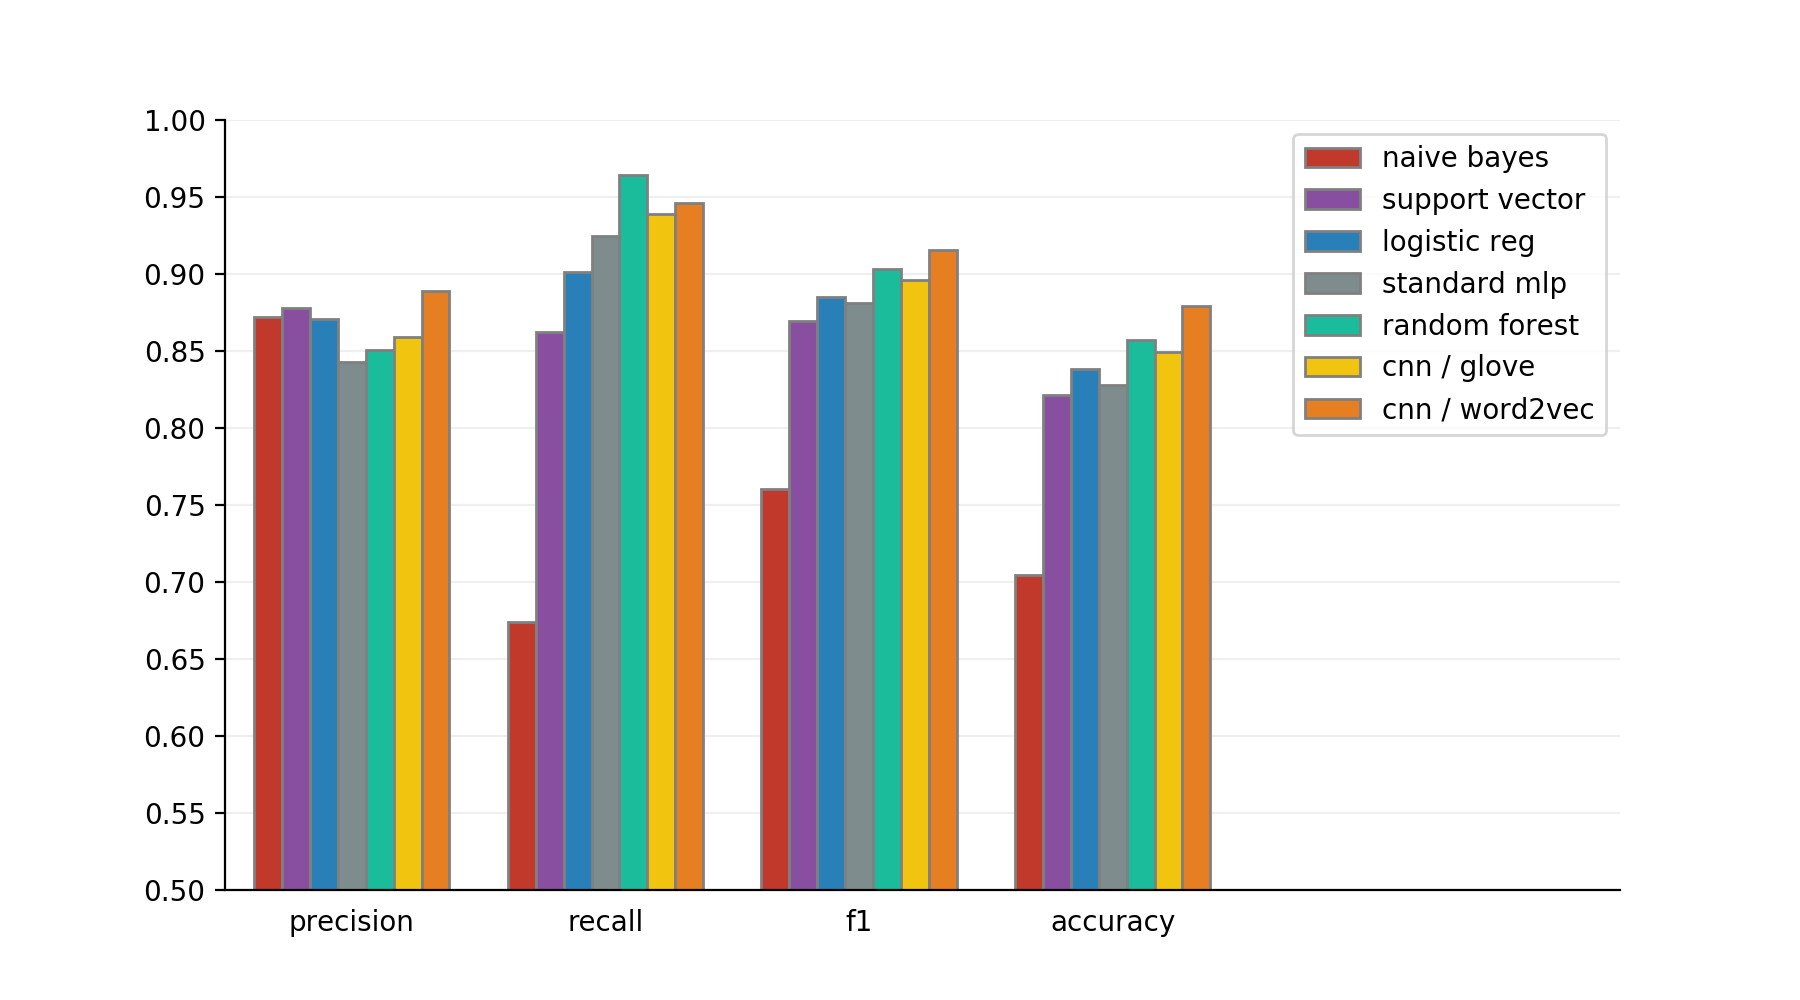

In [34]:
metrics = ['precision', 'recall', 'f1', 'accuracy']
x = np.array([1, 2, 3, 4])
rf_y = [np.mean(rf['precision']), np.mean(rf['recall']), np.mean(rf['f1']), np.mean(rf['acc'])]
nb_y = [np.mean(nb['precision']), np.mean(nb['recall']), np.mean(nb['f1']), np.mean(nb['acc'])]
sv_y = [np.mean(sv['precision']), np.mean(sv['recall']), np.mean(sv['f1']), np.mean(sv['acc'])]
mlp_y = [np.mean(mlp['precision']), np.mean(mlp['recall']), np.mean(mlp['f1']), np.mean(mlp['acc'])]
logit_y = [np.mean(logit['precision']), np.mean(logit['recall']), np.mean(logit['f1']), np.mean(logit['acc'])]
cnn1_y = [np.mean(cnn1['precision']), np.mean(cnn1['recall']), np.mean(cnn1['f1']), np.mean(cnn1['acc'])]
cnn2_y = [np.mean(cnn2['precision']), np.mean(cnn2['recall']), np.mean(cnn2['f1']), np.mean(cnn2['acc'])]
plt.rcParams["figure.figsize"] = (9,5)
%matplotlib notebook
w = 0.11
ax = plt.subplot(111)
ax.bar(x - 3 * w, nb_y, color='#C0392B', align='center', label='naive bayes', width=w, edgecolor='gray')
ax.bar(x - 2 * w, sv_y, color='#884EA0', align='center', label='support vector', width=w, edgecolor='gray')
ax.bar(x - w, logit_y, color='#2980B9', align='center', label='logistic reg', width=w, edgecolor='gray')
ax.bar(x, mlp_y, color='#7F8C8D', align='center', label='standard mlp', width=w, edgecolor='gray')
ax.bar(x + w, rf_y, color='#1ABC9C', align='center', label='random forest', width=w, edgecolor='gray')
ax.bar(x + 2 * w, cnn1_y, color='#F1C40F', align='center', label='cnn / glove', width=w, edgecolor='gray')
ax.bar(x + 3 * w, cnn2_y, color='#E67E22', align='center', label='cnn / word2vec', width=w, edgecolor='gray')
plt.xlim(0.5, 6)
plt.ylim(0.5, 1)
plt.legend()
plt.xticks(x, metrics, rotation='horizontal')
plt.yticks(np.arange(0.50, 1.05, 0.05))
ax.tick_params(axis="x", bottom=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(which='major', axis='y', alpha=0.2)
ax.set_axisbelow(True)
plt.show()

---

---
### 11. Train final CNN with all labeled data

In [35]:
print(category.shape)
print(texts.shape)

(1360,)
(1360,)


In [36]:
MAX_SEQUENCE_LENGTH = None
EMBEDDING_DIMS = 300
NUM_WORDS = 1000
BATCH_SIZE = 1280
FILTERS = 32
HIDDEN_DIMS = 128
EPOCHS = 50
DROPOUT_RATE = 0.4
    
category_val = category
texts_val = texts
category_train = category
texts_train = texts

x_val, x_train, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, texts_val, texts_train, MAX_SEQUENCE_LENGTH)

y_val, y_train = y_to_int(category_val, category_train)

embedding_matrix = get_embedding_matrix(EMBEDDING_DIMS, word_index, embeddings_index_google)

model, acc, precision, recall, f1, history, probs, fitted = fit_cnn_multi(BATCH_SIZE, EMBEDDING_DIMS, FILTERS, 
                                                                          HIDDEN_DIMS, EPOCHS, DROPOUT_RATE, 
                                                                          MAX_SEQUENCE_LENGTH,
                                                                          x_train, y_train, x_val, y_val, 
                                                                          word_index, embedding_matrix, verbose=False)

CNN validation accuracy: 0.9632353186607361


---
### 12. Apply trained CNN to all data

In [37]:
def apply_trained_model(df, model, MAX_SEQUENCE_LENGTH, tokenizer):

    print(f'The data has {df.shape[0]} rows.')

    # convert the text col to a numpy array
    texts = np.array(df['text']).astype(str)

    sequences = tokenizer.texts_to_sequences(texts)
    x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # convert text to the required input format
    #_, x, MAX_SEQUENCE_LENGTH, word_index, tokenizer = build_sequences(NUM_WORDS, None, texts, MAX_SEQUENCE_LENGTH)

    # apply trained model and get predictions
    probs = model.predict(x, batch_size=BATCH_SIZE, verbose=False)
    print(model.summary())
    fitted = probs > 0.5
    df['relevant'] = fitted
    df['relevant_probability'] = probs

    return df

In [38]:
# load the data
df1 = pd.read_csv('data_raw/results_feralswine_05012019to11042019.csv')
df2 = pd.read_csv('data_raw/results_wildpigs_05012019to11042019.csv')
df3 = pd.read_csv('data_raw/results_wildhogs_05012019to11042019.csv')

# add sentiment
df1 = apply_trained_model(df1, model, MAX_SEQUENCE_LENGTH, tokenizer)
df2 = apply_trained_model(df2, model, MAX_SEQUENCE_LENGTH, tokenizer)
df3 = apply_trained_model(df3, model, MAX_SEQUENCE_LENGTH, tokenizer)

# write to disk
df1.to_csv('data_raw/results_feralswine_05012019to11042019.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
df2.to_csv('data_raw/results_wildpigs_05012019to11042019.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
df3.to_csv('data_raw/results_wildhogs_05012019to11042019.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

/Users/ama/NWRC/Venv/cnn-nlp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The data has 3622 rows.
Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 63)           0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 63, 300)      2038200     input_22[0][0]                   
__________________________________________________________________________________________________
conv1d_46 (Conv1D)              (None, 62, 32)       19232       embedding_16[0][0]               
__________________________________________________________________________________________________
conv1d_47 (Conv1D)              (None, 61, 32)       28832       embedding_16[0][0]               
___________________________________________________________________

In [94]:
print(f" {100 * round(np.sum(df1['relevant']) / df1.shape[0], 2)}% of rows from feral swine search are relevant.")
print(f" {100 * round(np.sum(df2['relevant']) / df2.shape[0], 2)}% of rows from wild pig search are relevant.")
print(f" {100 * round(np.sum(df3['relevant']) / df3.shape[0], 2)}% of rows from wild hog search are relevant.")

 93.0% of rows from feral swine search are relevant.
 69.0% of rows from wild pig search are relevant.
 75.0% of rows from wild hog search are relevant.


---